In [1]:
import numpy as np
import PIL.Image as im
import tensorflow as tf
import tensorflow.keras.layers as tfl
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.utils.vis_utils import plot_model


In [2]:
os.listdir("/kaggle/input/cmscommon2/")

['Images']

In [3]:
train_datagen= ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)
train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/cmscommon2/Images',
        target_size= (125,125),
        color_mode='rgb',
        batch_size=32,
        class_mode='binary',
        subset='training',
        shuffle = True
)

validation_generator = train_datagen.flow_from_directory(
        '/kaggle/input/cmscommon2/Images',
        target_size= (125,125),
        color_mode='rgb',
        batch_size=32,
        class_mode='binary',
        subset='validation',
        shuffle = True

)



Found 111446 images belonging to 2 classes.
Found 27860 images belonging to 2 classes.


In [4]:
base_model = tf.keras.applications.EfficientNetB0(input_shape= (125,125,3), 
                                                  weights  = "imagenet",
                                                  include_top = False
                                                 )


2022-04-14 23:20:17.612094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 23:20:17.725660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 23:20:17.726403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 23:20:17.727715: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

16719872/16705208 [==============================] - 0s 0us/step


In [5]:
base_model.trainable = True


In [6]:
inputs = tf.keras.Input(shape=(125,125,3))
x = tf.keras.layers.RandomFlip()(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = base_model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256 , activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [8]:
from tensorflow_addons.optimizers import CyclicalLearningRate
cyclical_learning_rate = CyclicalLearningRate(
 initial_learning_rate=1e-6,
 maximal_learning_rate=1e-3,
 step_size=1000*6,
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')


In [7]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=cyclical_learning_rate ,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name = "auc")]
)

In [8]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./cp_{epoch}_.ckpt",
    monitor='val_auc',
    verbose=1,
    save_weights_only=True,
    mode='auto',
    save_freq = 1000
)

In [10]:
history = model.fit(
        train_generator,
        validation_data = validation_generator,
        validation_steps = 500,
        epochs=200,
        steps_per_epoch = 1000,
        verbose = 2,
        callbacks = [checkpoint]
)

2022-04-14 23:20:23.029979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-04-14 23:20:32.080350: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005



Epoch 00001: saving model to ./cp_1_.ckpt
1000/1000 - 156s - loss: 0.6612 - auc: 0.6583 - val_loss: 0.6282 - val_auc: 0.7057
Epoch 2/200

Epoch 00002: saving model to ./cp_2_.ckpt
1000/1000 - 124s - loss: 0.6316 - auc: 0.7038 - val_loss: 0.6110 - val_auc: 0.7322
Epoch 3/200

Epoch 00003: saving model to ./cp_3_.ckpt
1000/1000 - 117s - loss: 0.6064 - auc: 0.7364 - val_loss: 0.5867 - val_auc: 0.7602
Epoch 4/200

Epoch 00004: saving model to ./cp_4_.ckpt
1000/1000 - 114s - loss: 0.6004 - auc: 0.7431 - val_loss: 0.5884 - val_auc: 0.7562
Epoch 5/200

Epoch 00005: saving model to ./cp_5_.ckpt
1000/1000 - 110s - loss: 0.5959 - auc: 0.7494 - val_loss: 0.5830 - val_auc: 0.7642
Epoch 6/200

Epoch 00006: saving model to ./cp_6_.ckpt
1000/1000 - 108s - loss: 0.5906 - auc: 0.7557 - val_loss: 0.5979 - val_auc: 0.7547
Epoch 7/200

Epoch 00007: saving model to ./cp_7_.ckpt
1000/1000 - 109s - loss: 0.5903 - auc: 0.7551 - val_loss: 0.5758 - val_auc: 0.7741
Epoch 8/200

Epoch 00008: saving model to ./cp

In [ ]:
import pandas as pd

pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)

In [3]:
history = pd.read_csv("./History.csv")

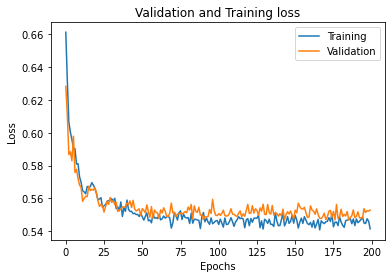

In [5]:
plt.plot(np.array(range(0,200)), np.array(history["loss"]) , label = "Training")
plt.plot(np.array(range(0,200)), np.array(history["val_loss"]) , label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validation and Training loss")
plt.legend()
plt.show()

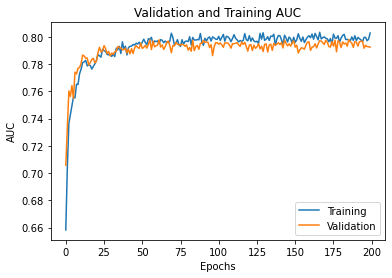

In [6]:
plt.plot(np.array(range(0,200)), np.array(history["auc"]) , label = "Training")
plt.plot(np.array(range(0,200)), np.array(history["val_auc"]) , label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.title("Validation and Training AUC")
plt.legend()
plt.show()

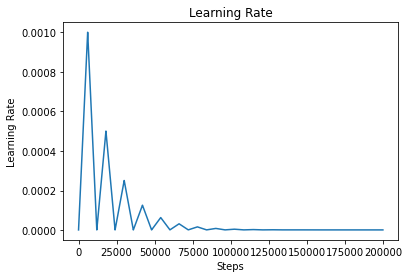

In [10]:
step = np.arange(0, 200 * 1000)
lr = cyclical_learning_rate(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate")
plt.show()
